# Brendan Lucas CHEM 608 Final Assignment:
# Comparing optimizers in deep learning to build chemical thermodynamic intuition
# May 13, 2025

In stochastic thermodynamics, the Kullback-leibler divergence is linearly related to a free energy difference from equilibrium via $D=-\beta\Delta F$, with $\beta=1/k_B T$ the invere temperature. This is relevant to deep learning, because minimum Kullback-Leibler divergence is equivalent to minimum cross entropy loss in training neural networks. In this sense, gradient descent minimizing cross entropy is not unlike dissipation producing physical entropy.

Furthermore, the scalar temporal Fisher information $I_F(t)$ has been shown to put a speed limit on the rate of heat dissipation via the time-information uncertainty relation. This Fisher can be conceptualized as a 1x1 Fisher information matrix with time as the sole parameter. This matrix is the Riemmanian metric tensor at the heart of deep learning's second-order optimization problem, called "natural gradient descent."

Using the Fashion MNIST dataset as a vehicle to focus on the performance of these algorithms, we explore simple linear neural networks, neural networks with one hidden layer, varying learning rates, different activation functions, and LASSO regularization as a way to compare the relative performance of standard gradient descent, natural gradient descent, and, as a related third, the Adam optimizer. This way we gain experience with building more complex models, and a stronger intuition for Fisher information and the Kullback-Leibler divergence which we can bring back to problems in thermodynamics, and therefore chemistry.

# Setting up Torch

I hypothesize ReLU, being less of a smooth nonlinearity in my intuition, to give standard gradient descent higher performance than NGD. On the contrary, I hypothesize tanh to lead to more performance for NGD than SGD.

In [1]:
import time # Compare performance
import torch # The PyTorch library
import torch.nn as nn # To create neural network "modules"
import torch.nn.functional as F # For activation functions
from torchvision import transforms # To parse data before training
from torchvision.datasets import FashionMNIST # The data
# Import individual objects for more pythonic syntax
from torch.utils.data import DataLoader
from numpy import mean
from matplotlib import pyplot as plt

# Global pytorch seed;
# python's random.seed() will not affect
# the outcomes of PyTorch's random processes
torch.manual_seed(1)

# Setting up the Data

In [2]:
"""
"Normalization: Data transformations, such as scaling or normalizing features,
 when incorrectly applied to both training and test data together,
 rather than applied separately, lead to data leakage."
 https://www.ibm.com/think/topics/data-leakage-machine-learning
"""

# Download and load the training data
trainset = FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True,
                        train=True, transform=transforms.ToTensor())

imgs = torch.stack([img for img, _ in trainset],dim=1)
imgview = imgs.permute(1, 0, 2, 3).view(1, -1)
train_mean = imgview.mean(dim=1)
train_std = imgview.std(dim=1)

# Normalize the training data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(train_mean,),
                                                     std=(train_std,))])

trainset = FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=False,
                        train=True, transform=transform)

# Download and normalize the test data
testset = FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True,
                       train=False, transform=transform)

# Examining the Data

Training dataset size: 60000
Testing dataset size: 10000
torch.Size([1, 28, 28])


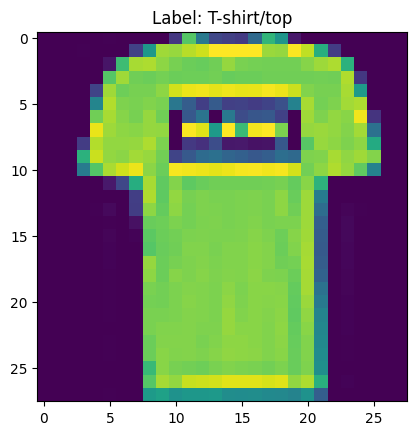

torch.Size([1, 28, 28])


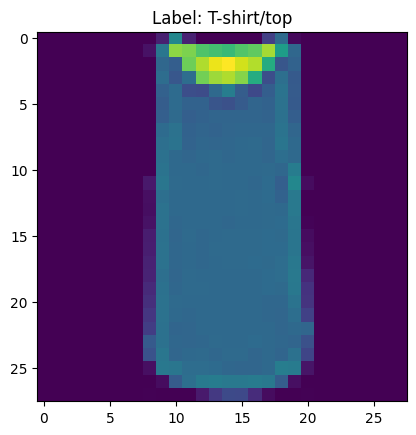

torch.Size([1, 28, 28])


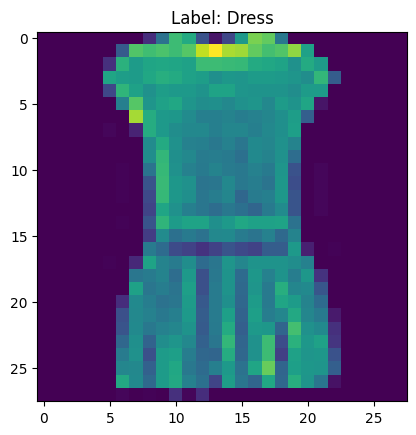

torch.Size([1, 28, 28])


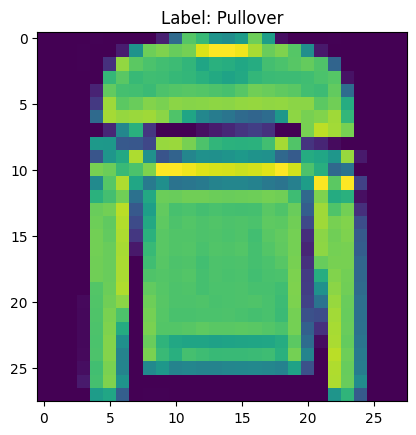

torch.Size([1, 28, 28])


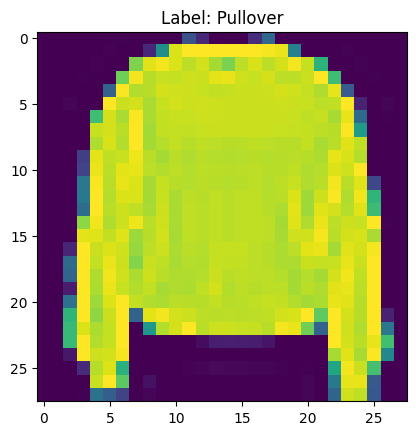

In [3]:
# Print the sizes of the datasets
print("Training dataset size:", len(trainset))
print("Testing dataset size:", len(testset))

labels = ['T-shirt/top', 'Trouser', 'Pullover',
          'Dress', 'Coat', 'Sandal', 'Shirt',
          'Sneaker', 'Bag', 'Ankle boot']

# Display some of the images
for item in [trainset[1], trainset[2], trainset[3], trainset[5], trainset[7]]:
  img, index = item
  print(img.shape)
  plt.imshow(img.squeeze())
  plt.title(f'Label: {labels[index]}')
  plt.show()

# Defining two model architectures: Linear Classifier, One Hidden Layer



In [4]:
# This is the simplest kind of network, with no hidden layers.
class SimpleLinear(nn.Module):
  # init creates the model object
  def __init__(self, input_size, num_classes):
    # input_size is the number of different elements in a datapoint
    # that is, the amount of pixels in one image.
    super(SimpleLinear, self).__init__()

    #nn.Linear() creates a weight tensor of shape (num_classes, input_size)
                        # and a bias tensor of shape (num_classes,)
    self.linear_layer = nn.Linear(input_size, num_classes)

  def forward(self, x_input): # There is no activation function
    x_vector = x_input.view(x_input.size(0), -1) # "Flattened" the x_input
    out_logits = self.linear_layer(x_vector)     # x_input is the entire batch
    return out_logits

# This is a fully connected network, with one hidden layer.

# This is for one hidden layer. I wonder if NGD takes longer and does better
# the more layers there are. It's worth investigating at least two, too.
class OneHidden(nn.Module): #pass activation_function=F.relu, F.tanh, etc.
  def __init__(self, input_size, hidden_size, num_classes, activation_function):
    super(OneHidden, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.activation_function=activation_function
  def forward(self, x_input):
    x_vector = x_input.view(x_input.size(0), -1)
    x_activated = self.activation_function(self.fc1(x_vector))
    out_logits = self.fc2(x_activated)
    return out_logits

#Regularization is part of the training loop, not the model architecture.
#You can define a Gaussian activation function as a simple python function
#Next comes define gradient and natural gradient descent.
#Stochastic gradient descent is an optional secondary.
#Stochastic natural gradient descent is an optional tertiary.
#It is important to consider training time as well as prediction accuracy

In [5]:
# Load the train and test data as one batch for standard and natural gradient descent
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)



# Function to Train a Model in PyTorch (ADD REGULARIZATION IF TIME)

In [6]:
def model_train(model, criterion, optimizer,
                     trainloader, testloader,
                     num_epochs,
                     lasso_hyperparameter=0):

  # If the trainloader batch size is len(trainloader), this is ordinary gradient descent (GD).
  # If the trainloader batch size is less than len(trainloader), it's stochastic GD (SGD).

  # This performance data will be returned
  epoch_training_times = []
  epoch_accuracies = []

  # This is the training loop
  for epoch in range(num_epochs):

    #start timer
    # Set model to "training mode"
    model.train()

    batch_training_times = []
                      #inputs are the images, labels are 0-9
    for input_images, true_labels in trainloader:
      #This loop only goes once if there is only one batch

      # Start the clock
      batch_time_start = time.perf_counter()

      # "Zero the gradient" does not mean "solve ∇L=0"
      # It means "reset the calculated gradient from previous epoch"
      # This line resets calculations; it doesn't calculate anything.
      optimizer.zero_grad()

      # "Forward pass" computes current (label) predictions of model
      # Training logit scores are assigned to the prediction labels 0-9
      # Softmax will convert these logit scores into probabilities.
      train_logit_scores = model(input_images)

      # Calculate the loss of the output labels
      loss = criterion(train_logit_scores, true_labels)

      # This is the optional lasso regularization penalty
      if lasso_hyperparameter != 0:
          loss += lasso_hyperparameter * torch.sum(torch.stack([torch.norm(p, p=1) for p in model.parameters() if p.dim() > 1])) 

      # This line * computes the estimated gradient with respect to parameters*
      # This part is the so-called back-propagation
      loss.backward()

      # Update the parameters
      # Actually modifies the model object's scalar params
      optimizer.step()

      # Stop the clock and compute Δt
      batch_time_end = time.perf_counter()
      batch_time = batch_time_end - batch_time_start
      batch_training_times.append(batch_time)

    # Set model to evaluation mode
    model.eval()

    # Turn off autograd so as not to waste compute or memory
    with torch.no_grad():

      correct_predictions = 0
      total_samples = 0

      for test_images, true_labels in testloader:
        test_logit_scores = model(test_images)

        # The predicted labels are the one with the highest logit score
        # What is forgotten by the underscore is the max logits themselves.
        _, predicted_labels = torch.max(test_logit_scores.data, 1)

        total_samples += true_labels.size(0)
        # Sum (1 if correct, 0 if not); .item() returns int from 1x1 tensor
        correct_predictions += (predicted_labels == true_labels).sum().item()

      # Here we evaluate optimization performance

      epoch_time = sum(batch_training_times)
      epoch_training_times.append(epoch_time)

      epoch_accuracy = correct_predictions / total_samples
      epoch_accuracies.append(epoch_accuracy)

  return model, epoch_training_times, epoch_accuracies

# Basic parameters for training simple linear models for Fashion MNIST(SLMFMNISTs)

In [7]:
learning_rate=0.01 #modify as needed
num_epochs=8 #modify as needed

# What is gradient descent?

Gradient descent can be summarized by the following formula,

$$\vec{w}_{t+1} = \vec{w}_t - \alpha \nabla\mathcal{L}(\vec{w}_t),$$

a variant of which we went over in class. Basically, the vector $\vec{w}$ are the parameters of a model for the data. The model is a probability distribution. The cost function $\mathcal{L}$ is, in this case, the "cross entropy," which is the negative-log-likelihood (NLL or $-\ln L$ of a model whose outputs $z_i$ are normalized by the softmax function:

$$\sigma(z_i)=\frac{e^{z_i}}{\sum_j e^{z_j}}$$

$\sigma(z_i)$ confirms model outputs $z_i$ into normalized quantities than can be interpreted as probabilities.

As we learned in class, the maximum likelihood principle would have us wanting this $\mathcal{L}$ to decrease to a minimum with zero gradient $\nabla \mathcal{L} = \vec{0}$. That is the optimization problem. 

The reason we take the negative of the cost/loss function's gradient is because it provides a direction for us to "push" the model (technically, as a point estimate on a statistical manifold) to improve its performance, as defined by $\mathcal{L}$ itself.

If the $k$th element of $\nabla\mathcal{L}(\vec{w})$ is positive, that means a positive adjustment in the $k$th element of $\vec{w}$ will lead to a positive change in $\mathcal{L}(\vec{w})$ (which is bad). Therefore we will like to make a negative change in the $k$th element of $\vec{w}$ when the $k$th element of $\nabla\mathcal{L}(\vec{w})$ is positive; the same applies for all the other elements, and we will likewise want a positive change in each element of $\vec{w}$ for which the corresponding elements of $\nabla\mathcal{L}(\vec{w})$ are negative. **That is why there is a negative sign in front of the adjustment by $\alpha\nabla\mathcal{L}(\vec{w})$**. The hyperparameter $\alpha$ only determines the rate at which these adjustments take place (hence the name "learning rate"), and, if relevant, converts the gradient to the dimensions of $\vec{w}$. 

Gradient descent is basically updating the $\vec{w}$ with the formula $\vec{w}_{t+1} = \vec{w}_t - \alpha \nabla\mathcal{L}(\vec{w}_t)$ until the point estimate of the model is as close as possible to $\nabla\mathcal{L}=\vec{0}$.

# Training a Simple Linear Model for Fashion MNIST with gradient descent (SLMFMNISTGD)

In [8]:
crossent_criterion = nn.CrossEntropyLoss()

In [9]:
# Same learning rate for gradient descent as for natural gradient descent?
SLMFMNISTGD = SimpleLinear(input_size=28*28, num_classes=10)
# SGD is the stochastic gradient descent function
# But if "full-batch" so batch_size=len(trainset), it is just gradient descent.
gd_optimizer = torch.optim.SGD(SLMFMNISTGD.parameters(), lr=learning_rate)

## Examining the parameters of SLMFMNISTGD

In [10]:
# This model has two parameter-tensors.
print(len(list(SLMFMNISTGD.parameters())))

all_parameters=list(SLMFMNISTGD.parameters())

weight_tensor = all_parameters[0]
bias_tensor = all_parameters[1]

print('weight tensor shape: ', weight_tensor.shape)
print('bias tensor shape: ', bias_tensor.shape)

2
weight tensor shape:  torch.Size([10, 784])
bias tensor shape:  torch.Size([10])


The total number of parameter-tensors is 2, a weight tensor and a bias tensor.

The total number of scalar parameters is $10\times 784 + 10=7850$.

## Training SLMFMNISTGD

In [11]:
# It would be wise to do this on own hardware to report exact specs
(SLMFMNISTGD_trained,
 SLMFMNISTGD_training_times,
 SLMFMNISTGD_accuracies) = model_train(model=SLMFMNISTGD,
                                            criterion=crossent_criterion,
                                            optimizer=gd_optimizer,
                                            trainloader=trainloader,
                                            testloader=testloader,
                                            num_epochs=num_epochs)

In [12]:
print(SLMFMNISTGD_training_times)
print(SLMFMNISTGD_accuracies)

[0.038845029000185605, 0.04482195699984004, 0.031966043000466016, 0.0324123000000327, 0.03884527600075671, 0.03173555200010014, 0.04654519999985496, 0.032624661999761884]
[0.0977, 0.2188, 0.3403, 0.437, 0.5067, 0.5602, 0.5912, 0.6138]


# What is natural gradient descent?

Gradient descent, as described above, provides the direction of steepest descent for a model whose lost/cost function $\mathcal{L}$ exists as a point in a Euclidean space. However,the space ("statistical manifold") which encompasses the set of all models with a certain architecture may be curved. The geometry of curved spaces is known as Riemannian geometry.

In Euclidean geometry, the distance between two points $\vec{w}_1$ and $\vec{w}_2$ is given by $|d\vec{w}|^2=\sum_i (dw_i)^2$, which is the distance formula similar to the Pythagorean theorem ("remember ninth grade!"). In a Riemmanian geometry, we generalize the distance formula with some $g_{ij}$ that make it so different elements of $\vec{w}$ can interact in affecting the overall distance:

$$|d\vec{w}|^2 = \sum_{i, j} g_{ij}(\vec{w}) dw_i dw_j,$$

where the factors $g_{ij}(\vec{w})$ are the elements of the "Riemmanian metric tensor," a 2d matrix $G$. In Euclidean geometry, the Riemmanian metric tensor is the identity matrix, so $g_{ii}=1$ when $i=j$ and $g_{ij}=0$ when $i\neq j$.

It is a fundamental theorem of Riemmanian geometry that the direction of steepest descent (the "natural gradient") for a function $f(\vec{w})$ is given by the Euclidean gradient and the *inverse* of the metric tensor:

$$\nabla_{\text{nat}}f(\vec{w}) = G^{-1}(\vec{w})\nabla f(\vec{w})$$

In the space of $\mathcal{L}$, the Riemmanian metric tensor is the Fisher information matrix

$$\mathcal{I}_F(\vec{w})_{ij}=\begin{bmatrix}
    \frac{\partial L}{\partial w_i}\frac{\partial L}{\partial w_j}
\end{bmatrix}$$

the approximation of which is called the "second order optimization problem." The open source code I borrowed in the next cell updates the weights by approximating the following "natural gradient descent" formula: 

$$\vec{w}_{t+1} = \vec{w}_t - \alpha \mathcal{I}_F^{-1}\nabla \mathcal{L}(\vec{w}_t),$$

inverting the Fisher information matrix (a difficult task when there are thousands of parameters!). The code we imported uses a reduced-rank approximation of this matrix.

# Importing Open Source Natural Gradient Descent (NGD) Optimizer (Apache 2.0)

## https://github.com/YiwenShaoStephen/NGD-SGD/blob/master/ngd.py



In [13]:
#@title YiwenShaoStephen/NGD-SGD
import math
import sys
from torch.optim.optimizer import Optimizer, required


class OnlineNaturalGradient:
    r"""This object is used in the `NGD` object which is the actual optimizer.
    It is derived from the OnlineNaturalGradient object in Kaldi's
    src/nnet3/natural-gradient-online.h, and the ideas are explained in
    "Parallel training of DNNs with Natural Gradient and Parameter Averaging"
    by D. Povey, X. Zhang and S. Khudanpur, ICLR Workshop, 2015.  But the
    way it is implemented here in PyTorch is a little different, because, due
    to how the automatic differentiation works, we can't easily get access
    to the matrix multiplication or summation that gave us this particular
    derivative.  So we basically treat all the "other" dimensions of the
    parameter object as if they were the minibatch dimension.
    """

    def __init__(self, params, axis, alpha=4.0,
                 rank=-1, update_period=4,
                 eta=0.1):
        r"""
      Constructor.
    Arguments:
        params:       The parameters we are going to operating on. Used
                      to get the device, dtype and shape; the parameter
                      values do not matter at this point.
        axis:         A value in the range [0, len(param_shape) - 1],
                      saying which axis of the parameters this object
                      operates on.  The dimension of the low-rank matrix
                      that we are learning will be equal to params.shape[axis].
        alpha:        A smoothing constant which determines how much
                      we smooth the Fisher matrix with the identity;
                      the scale on the identity is the average diagonal
                      element of the un-smoothed Fisher matrix multiplied by
                      alpha.  The value alpha=4.0 tends to work well
                      experimentally in a wide range of conditions (when
                      measured in terms of classification performance
                      on validation data, not as an optimiser), although
                      perhaps alpha=4.0 represents a perhaps larger-than-expected
                      amount of smoothing.
        rank:         The rank of the structured matrix that we will be
                      updating.  If a value <0 is passed in, it
                      will be set to the smaller of (dim+1) / 2, or 80,
                      where dim = params.shape[axis].
        update_period: Determines how frequently (on how many minibatches
                      we update the natural-gradient matrix; the default
                      of 4 is reasonable.
        eta           A Python float strictly between 0 and 1, that determines how fast
                      we update the Fisher-matrix factor.
                      i.e. F_t = \eta * S_t + (1 - \eta) F_{t-1}, where S_t is the emperical
                      Fisher estimated from the current minibatch.
        """
        assert axis >= 0 and axis < len(params.shape)
        self.axis = axis
        self.dim = params.shape[axis]
        assert(self.dim > 0)
        self.device = params.device
        self.dtype = params.dtype
        self.alpha = alpha
        if rank >= 0:
            assert(rank > 0 and rank < self.dim)
        else:
            rank = min((self.dim + 1) // 2, 80)
        self.rank = rank
        assert(update_period > 0)
        self.update_period = update_period
        assert eta > 0 and eta < 1
        self.eta = eta
        self.rank = rank

        # epsilon and delta are two values involved in making sure the Fisher
        # matrix isn't singular and that we don't get NaN's appearing; we don't
        # make them configurable.
        self.epsilon = 1.0e-10
        self.delta = 5.0e-4

        # t is a counter that records how many times self.precondition_directions()
        # has been called.
        self.t = 0
        # We won't initiailize the members
        # self.W_t, self.rho_t, self.d_t
        # until someone uses the class.
        self.debug = False

    r"""
    This string contains documentation of the data members of this class.  These are not
    part of the public interface, but we document them for clarity and to make it easier
    to understand the internals.

      self.dim  An int containing the dimension >= 1 that this object operates on; this
                is the dimension (num-rows/cols) of the Fisher matrix that this class
                does a multiplication by.
      self.axis An int >= 0 that is the axis of the parameters which we'll be operating
                on (our Fisher-matrix factor is a square matrix of dimension
                dim = params.shape[self.axis]).
      self.device  The torch.device object that the parameter and derivs live on;
                we will keep the inverse-Fisher-matrix factor W_t, and many temporary
                quantities used in the algorithm, on this device for speed.
      self.dtype  The torch.dtype representing the type of the parameters and derivs;
                expected to be float or double.
      self.alpha  A Python float that determines how much we smooth the Fisher matrix
                with the identity; the default (4.0) represents very aggressive
                smoothing, such that all the NGD is really doing is slowing us down
                in the really dominant directions, but not really speeding us up
                in the dimensions where there is very little variation.
      self.rank  [only if self.dim > 1] A python int in the  range [1, self.dim - 1]
                which is the rank of the low-rank-plus-identity approximation
                to the Fisher matrix.  If self.dim == 1, this object is a no-op
                and we treat the Fisher matrix as the identity matrix [ 1 ], and
                self.rank (and various other class members) are not defined.
      self.update_period  A Python int that determines how frequently (i.e.
                every how-many minibatches) we update the Fisher-matrix factors.
                The default is 4.
      self.eta  A Python float strictly between 0 and 1, that determines how fast
                we update the Fisher-matrix factor.
                i.e. F_t = \eta * S_t + (1 - \eta) F_{t-1}, where S_t is the emperical
                Fisher estimated from the current minibatch.
      self.epsilon, self.delta  Python floats equal to 1e-10 and 5e-4, which go into
                determining minimum eigenvalues of the Fisher-matrix approximation,
                mostly to avoid situations where our update would be unstable or
                generate NaN's.  These values aren't user configurable.  See
                the paper.
      self.debug  A python bool; if true, certain debugging code will be activated.

     The following variables change with time:
      self.t    A Python int >= 0, which equals the number of times the function
                self.precondition_directions() has been called by the user.  It
                helps to determine on which iterations we update the Fisher-matrix
                approximation.
      self.W_t  A torch.tensor with shape (self.rank, self.dim), device self.device
                and dtype self.dtype, corresponding to
                a factor of the inverse Fisher matrix; it's W_t in the math, see the paper.
      self.d_t_cpu  A torch.tensor with shape (self.rank), device 'cpu' and
                dtype self.dtype, which contains the eigenvalues of the inverse Fisher
                matrix (or is it the Fisher matrix?)... anyway, it's described in the paper.
      self.rho_t  A Python float that is a scale on the unit part in the Fisher-matrix
               approximation on the current iteration (or maybe its inverse, check the
                paper).
    """

    def precondition_directions(self, deriv):
        r"""
        Implements the main functionality of this class; takes the derivative
        "deriv" and returns the 'preconditioned' derivative.

        This function just reorganizes the dimensions and calls
        _precondition_directions1().
        """
        assert deriv.shape[self.axis] == self.dim
        if self.dim == 1:
            return deriv  # This class is o a no-op in that case.

        # What the following statement does is to switch axes so that the axis
        # we operate on (of dim self.dim) is the last one, call
        # self._precondition_directions1, and then switch the axes back.  All
        # this would be done without changing the underlying data.
        return torch.transpose(self._precondition_directions1(deriv.transpose(-1, self.axis)),
                               -1, self.axis)

    def _precondition_directions1(self, deriv):
        r"""
        Internal version of precondition_directions() that expects
        the axis we operate on to be the last axis in the tensor.  So at this point
        we can proceed as if self.axis == len(deriv.shape) - 1.
        The preconditioned derivative that this function returns
        is in the same format.
        """

        assert deriv.shape[-1] == self.dim

        deriv = deriv.contiguous()
        # The following call combines the leading axes into a single axis,
        # so that _preconditions2 can operate on a tensor of shape
        # (remaining_dims_product, dim), calls _precondition_directions2 and
        # then switches back to the shape this function was called with.
        return self._precondition_directions2(deriv.view(-1, self.dim)).view(deriv.shape)

    def _precondition_directions2(self, deriv):
        r""" This corresponds to PreconditionDirections() in the C++ code,
        except rather than modifying deriv in-place and returning a separate
        scaling factor, it returns the modified deriv with the scaling factor
        already applied.
        """
        # The following assert documents the format requirements on 'deriv'.
        assert (len(deriv.shape) == 2 and deriv.shape[1] == self.dim and
                deriv.dtype == self.dtype and deriv.device == self.device)

        if self.t == 0:
            self._init(deriv)

        initial_product = (deriv * deriv).sum()

        deriv_out = self._precondition_directions3(
            deriv, initial_product)

        final_product = (deriv_out * deriv_out).sum()

        if math.isnan(final_product):
            print("Warning: nan generated in NG computation, returning derivs unchanged",
                  file=sys.stderr)
            # If there are NaNs in our class members now, it would be a problem; in
            # future we might want to add code to detect this an re-initialize,
            # but for now just detect the problem and crash.
            self._self_test()
            return deriv

        # the + 1.0e-30 below is to avoid division by zero if the derivative is zero.
        return deriv_out * torch.sqrt(initial_product / (final_product + 1.0e-30))

    def _precondition_directions3(self, X_t, tr_X_Xt):
        """
        This does the 'really' core part of the natural gradient multiplication and
        (on some frames) it updates our Fisher-matrix estimate.  This corresponds,
        roughly, to PreconditionDirectionsInternal() in the C++ code.


        Arguments:
             X_t:     The matrix of derivatives (X_t in the math), a 2-dimensional
                      PyTorch tensor, expected to be on device self.device, and
                      X_t.shape[1] should equal self.dim.
             tr_X_Xt: The value of trace(X X^T) == (X * X).sum(), as a scalar
                      torch.tensor (i.e., with shape equal to ()).

        Return:
             Returns the matrix of derivatives multiplied by the inverse
             Fisher matrix.
        """
        updating = self._updating()
        self.t = self.t + 1
        rho_t = self.rho_t
        alpha = self.alpha
        eta = self.eta
        rank = self.rank
        dim = self.dim
        W_t = self.W_t
        d_t_cpu = self.d_t_cpu

        H_t = torch.mm(X_t, W_t.transpose(0, 1))  # H_t = X_t W_t^T

        # X_hat_t = X_t - H_t W_t
        X_hat_t = X_t - torch.mm(H_t, W_t)

        if not updating:
            # We're not updating the estimate of the Fisher matrix; we just
            # apply the preconditioning and return.
            return X_hat_t

        J_t = torch.mm(H_t.transpose(0, 1), X_t)  # J_t = H_t^T X_t

        # In the paper, N would be the number of rows in the matrix being
        # multiplied (would be related to the minibatch size).
        # In this version, it would be 1
        #N = 1
        N = X_t.shape[0]
        # we choose the fastest way to compute L_t, which depends
        # on the dimension.
        if N > dim:
            L_t = torch.mm(J_t, W_t.transpose(0, 1))  # L_t = J_t W_t^T
        else:
            L_t = torch.mm(H_t.transpose(0, 1), H_t)  # L_t = H_t^T H_t
        K_t = torch.mm(J_t, J_t.transpose(0, 1))  # K_t = J_t J_t^T

        K_t_cpu = K_t.to('cpu')
        L_t_cpu = L_t.to('cpu')

        # d_t_sum and beta_t are python floats.
        # in the math, d_t_sum corresponds to tr(D_t).
        d_t_sum = d_t_cpu.sum().item()
        beta_t = rho_t * (1.0 + alpha) + alpha * d_t_sum / dim

        # e_t is a torch.tensor with shape (rank,) on the CPU.
        # e_{tii} = 1/(\beta_t/d_{tii} + 1)
        e_t_cpu = 1.0 / (beta_t / d_t_cpu + 1.0)
        sqrt_e_t_cpu = torch.sqrt(e_t_cpu)
        inv_sqrt_e_t_cpu = 1.0 / sqrt_e_t_cpu

        # z_t_scale is an arbitrary value (mathematically it can be anything)
        # which we use to keep Z_t in a reasonable numerical range, since it
        # contains the derivatives to the fourth power which can otherwise get
        # large.  we'll divide by this when creating Z_t, and multiply by it
        # when using Z_t.
        z_t_scale = max(1.0, K_t_cpu.trace().item())
        # see eqn:zt in natural-gradient-online.h (the C++ code).  We are computing,
        # Z_t  = (\eta/N)^2 E_t^{-0.5} K_t E_t^{-0.5}
        #   +(\eta/N)(1-\eta) E_t^{-0.5} L_t E_t^{-0.5} (D_t + \rho_t I)
        #   +(\eta/N)(1-\eta) (D_t + \rho_t I) E_t^{-0.5} L_t E_t^{-0.5}
        #   +(1-\eta)^2 (D_t + \rho_t I)^2                              (eqn:Zt)
        #  [And note that E_t and D_t and I are all diagonal matrices, of which
        #   we store the diagonal elements only].
        # Actually the quantity Z_t_cpu here is equal to Z_t / z_t_scale;
        # the scale helps keep it in a good numerical range.

        d_t_plus_rho_t = d_t_cpu + rho_t
        # Note: torch.ger gives the outer product of vectors.
        inv_sqrt_e_t_outer = ((eta / N)**2 / z_t_scale) * \
            torch.ger(inv_sqrt_e_t_cpu,  inv_sqrt_e_t_cpu)
        outer_product1 = ((eta / N) * (1 - eta) / z_t_scale) * \
            torch.ger(inv_sqrt_e_t_cpu, inv_sqrt_e_t_cpu * d_t_plus_rho_t)

        Z_t_cpu = (K_t_cpu * inv_sqrt_e_t_outer +
                   L_t_cpu * (outer_product1 + outer_product1.transpose(0, 1)) +
                   (((1 - eta)**2 / z_t_scale) * (d_t_plus_rho_t * d_t_plus_rho_t)).diag())

        # do the symmetric eigenvalue decomposition Z_t = U_t C_t U_t^T; we do this
        # on the CPU as this kind of algorithm is normally super slow on GPUs, at least
        # on smallish dimensions (note: rank <= 80, with the default configuration).
        """
        @brendangerardlucas modification 5/12/25:
        Removed (c, U) = Z_t_cpu.symeig(True) from original; deprecated from torch
        """
        (c, U) = torch.linalg.eigh(Z_t_cpu, UPLO='U')
        # reverse the eigenvalues and their corresponding eigenvectors from largest
        # to smallest.  c_t_cpu still has the scale `1/z_t_scale`.
        c_t_cpu = c.flip(dims=(0,))
        U_t_cpu = U.flip(dims=(1,))

        if self.debug:
            error = torch.mm(U_t_cpu * c_t_cpu.unsqueeze(0),
                             U_t_cpu.transpose(0, 1)) - Z_t_cpu
            assert (error * error).sum() < 0.001 * \
                (Z_t_cpu * Z_t_cpu).sum()
        condition_threshold = 1.0e+06
        c_t_floor = ((rho_t * (1.0 - eta)) ** 2) / z_t_scale
        c_t_cpu = torch.max(c_t_cpu, torch.Tensor(
            [c_t_floor]))  # c_t_cpu.floor_(c_t_floor)
        # sqrt_c_t_cpu no longer has the `1/z_t_scale` factor, i.e. it is now
        # the same value as in the math.
        sqrt_c_t = c_t_cpu.to(self.device).sqrt() * math.sqrt(z_t_scale)
        inv_sqrt_c_t = (1.0 / sqrt_c_t)
        # \rho_{t+1} = 1/(D - R) (\eta/N tr(X_t X_t^T) + (1-\eta)(D \rho_t + tr(D_t)) - tr(C_t^{0.5})).
        rho_t1 = (1.0 / (dim - rank)) * ((eta / N) * tr_X_Xt.item() +
                                         (1.0 - eta) * (dim * rho_t + d_t_sum) -
                                         sqrt_c_t.sum().item())

        floor_val = max(self.epsilon, self.delta * sqrt_c_t.max().item())
        # D_{t+1} = C_t^{0.5} - \rho_{t+1} I,  with diagonal elements floored to floor_val.
        # we store only the diagonal.
        d_t1_cpu = torch.max(sqrt_c_t.to('cpu') - rho_t1,
                             torch.tensor(floor_val, dtype=self.dtype))
        if rho_t1 < floor_val:
            rho_t1 = floor_val

        # Begin the part of the code that in the C++ version was called ComputeWt1.
        # beta_t1 is a python float.
        # \beta_{t+1} = \rho_{t+1} (1+\alpha) + \alpha/D tr(D_{t+1})
        beta_t1 = rho_t1 * (1.0 + alpha) + alpha * d_t1_cpu.sum().item() / dim
        assert beta_t1 > 0
        # Compute E_{t+1} and related quanitities; the formula is the same for
        # E_t above. These are diagonal matrices and we store just the diagonal
        # part.
        e_t1_cpu = 1.0 / (beta_t1 / d_t1_cpu + 1.0)
        sqrt_e_t1 = torch.sqrt(e_t1_cpu.to(self.device))

        w_t_coeff = (((1.0 - eta) / (eta / N)) *
                     (d_t_cpu + rho_t)).to(self.device)
        # B_t = J_t + (1-\eta)/(\eta/N) (D_t + \rho_t I) W_t
        B_t = torch.addcmul(J_t, w_t_coeff.unsqueeze(1), W_t)

        # A_t = (\eta/N) E_{t+1}^{0.5} C_t^{-0.5} U_t^T E_t^{-0.5}
        left_product = torch.tensor(
            eta / N, device=self.device, dtype=self.dtype) * sqrt_e_t1 * inv_sqrt_c_t
        A_t = U_t_cpu.to(self.device).transpose(0, 1) * torch.ger(left_product,
                                                                  inv_sqrt_e_t_cpu.to(self.device))
        # W_{t+1} = A_t B_t
        W_t1 = torch.mm(A_t, B_t)
        # End the part of the code that in the C++ version was called ComputeWt1.

        self.W_t = W_t1
        self.d_t_cpu = d_t1_cpu
        self.rho_t = rho_t1
        # t has been incremented at the top of this function
        if self.debug:
            self._self_test()
        return X_hat_t

    def _self_test(self):
        assert self.rho_t >= self.epsilon
        d_t_max = self.d_t_cpu.max().item()
        d_t_min = self.d_t_cpu.min().item()
        assert d_t_min >= self.epsilon and d_t_min > self.delta * d_t_max * 0.9
        assert self.rho_t > self.delta * d_t_max * 0.9
        beta_t = self.rho_t * (1.0 + self.alpha) + \
            self.alpha * self.d_t_cpu.sum().item() / self.dim

        e_t = (1.0 / (beta_t / self.d_t_cpu + 1.0)).to(self.device)
        sqrt_e_t = torch.sqrt(e_t)
        inv_sqrt_e_t = 1.0 / sqrt_e_t

        should_be_zero = (torch.mm(self.W_t, self.W_t.transpose(0, 1)) *
                          torch.ger(inv_sqrt_e_t, inv_sqrt_e_t) - torch.eye(self.rank, device=self.device))
        assert should_be_zero.abs().max().item() < 0.1

    def _updating(self):
        r""" Returns true if, on this iteration, we are updating the Fisher
        matrix."""
        num_initial_iters = 10
        if self.t < num_initial_iters:
            return True
        else:
            return self.t % self.update_period == 0

    def _init(self, deriv):
        assert self.t == 0
        # _init_default() initializes W_t, rho_t and d_t to values that do
        # not depend on 'deriv'.
        self._init_default()
        # setting self.t to 1 will stop self._precondition_directions2 from
        # recursing to _init.
        self.t = 1
        # the following loop will do the standard update on each the 3
        # iterations, causing the low-rank matrix to get closer to what we would
        # get in a SVD-based initialization...  it's similar to the power
        # method.
        # Each time, we discard the return value of
        # self.precondition_directions2.
        for n in range(0, 3):
            self._precondition_directions2(deriv)

        # The calling code is going to increment self.t again, so reset it
        # to zero which is the value it will have had a entry; then self.t
        # will equal the value
        self.t = 0

    def _init_default(self):
        r"""Called from _init(), this function sets the parameters self.W_t,
        self.rho_t and self.d_t to some default values; they will then be
        updated by several iterations of the standard update but done with
        the same 'deriv'; this is a fast approximation to an SVD-based
        initialization."""
        assert self.rank < self.dim and self.rank > 0 and self.alpha > 0.0
        self.rho_t = self.epsilon
        # d_t will be on the CPU, as we need to do some sequential operations
        # on it.
        self.d_t_cpu = self.epsilon * \
            torch.ones((self.rank,), dtype=self.dtype)
        # W_t is on self.device (possibly a GPU).

        # E_tii is a scalar here, since it's the same for all i.
        E_tii = 1.0 / (2.0 + (self.dim + self.rank) * self.alpha / self.dim)
        self.W_t = math.sqrt(E_tii) * self._create_orthonormal_special()
        assert self.t == 0

    def _create_orthonormal_special(self):
        r"""This function, used in _init_default(), creates and returns a PyTorch
        tensor on device self.device and with dtype self.dtype, with shape
        (self.rank, self.dim) that is like the following:
          [  1.1 0   1   0   1
             0   1.1 0   1   0   ] * k
        where k is chosen so that each row has unit 2-norm.  The motivation is
        that this is faster than starting with a random matrix and
        orthonormalizing it with Gram-Schmidt.  The base matrix it starts with
        the identity times 1.1, then has copies of the identity to fill out the
        remaining dimensions.  The reason for this structure is, to ensure each
        row and column has a nonzero value; the 1.1 is for symmetry breaking
        since there may be architectures where the deriviative in the direction
        [1 1 1 1 .. 1 ] would be zero and having the sum of rows be equal to
        that value might cause the matrix after multiplying by the data derivs
        to be singular, which would put the code on a less efficient path
        involving CPU-based operations."""

        first_elem = 1.1
        num_cols = self.dim // self.rank
        remainder = self.dim % self.rank
        k = torch.ones(self.rank, dtype=self.dtype, device=self.device) * \
            (1.0 / math.sqrt(first_elem * first_elem + num_cols - 1))
        k[:remainder] = torch.ones(
            remainder, dtype=self.dtype, device=self.device) * (1.0 / math.sqrt(first_elem * first_elem + num_cols))
        diag_v = torch.ones(self.rank, dtype=self.dtype,
                            device=self.device) * k
        diag = torch.diag(diag_v)
        first_diag_v = diag_v * first_elem
        first_diag = torch.diag(first_diag_v)
        ans = torch.cat((first_diag, diag.repeat(
            1, num_cols + 1)), 1)[:, :self.dim]

        if self.debug:
            should_be_zero = (torch.mm(ans, ans.transpose(0, 1)) -
                              torch.eye(self.rank, dtype=self.dtype,
                                        device=self.device))
            s = should_be_zero.abs().max().item()
            assert s < 0.1
        return ans


class NGD(Optimizer):
    r"""Implements natural gradient (optionally with momentum).
        In future we may make some of the options of the NG user-modifiable
        but for now we use defaults that have been found to work well.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.NGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    TODO: more information
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False,
                 ngd=True, alpha=4, rank=-1, update_period=4, eta=0.1):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov,
                        ngd=ngd, alpha=alpha, rank=rank,
                        update_period=update_period, eta=eta)

        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError(
                "Nesterov momentum requires a momentum and zero dampening")

        super(NGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(NGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('ngd', True)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            ngd = group['ngd']
            alpha = group['alpha']
            rank = group['rank']
            update_period = group['update_period']
            eta = group['eta']
            lr = group['lr']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)

                if ngd:
                    param_state = self.state[p]
                    if 'ngd_dict' not in param_state:
                        ngd_dict = param_state['ngd_dict'] = dict()
                        for axis in range(len(p.shape)):
                            ngd_dict[axis] = OnlineNaturalGradient(
                                p, axis, alpha, rank, update_period, eta)

                    ngd_dict = param_state['ngd_dict']
                    for axis in range(len(p.shape)):
                        d_p = ngd_dict[axis].precondition_directions(d_p)

                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(
                            p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                p.data.add_(-lr, d_p)

        return loss

# Training a Simple Linear Model for Fashion MNIST with *natural* gradient descent (SLMFMNIST*N*GD)




In [14]:
# Same learning rate for gradient descent as for natural gradient descent
SLMFMNISTNGD = SimpleLinear(input_size=28*28, num_classes=10)
# NGD is the natural gradient descent function we cited above
ngd_optimizer = NGD(SLMFMNISTNGD.parameters(), lr=learning_rate)

In [15]:
# It would be wise to do this on own hardware to report exact specs
(SLMFMNISTNGD_trained,
 SLMFMNISTNGD_training_times,
 SLMFMNISTNGD_accuracies) = model_train(model=SLMFMNISTNGD,
                                            criterion=crossent_criterion,
                                            optimizer=ngd_optimizer, #*natural*
                                            trainloader=trainloader,
                                            testloader=testloader,
                                            num_epochs=num_epochs)

/tmp/ipykernel_7572/1166725308.py:593: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
  p.data.add_(-lr, d_p)


In [16]:
print(SLMFMNISTNGD_training_times)
print(SLMFMNISTNGD_accuracies)

[0.06221045499933098, 0.05036101899986534, 0.0336408079992907, 0.03593526300028316, 0.03444627499993658, 0.03257907399984106, 0.042704761999630136, 0.04344607300026837]
[0.0815, 0.1233, 0.1859, 0.2398, 0.2798, 0.3109, 0.3371, 0.3609]


# What is the Adam optimizer?

Adam is different from classical gradient descent and from natural gradient descent. It stands for "Adaptive moment estimation." One of the things it does differently from the gradient descent that we described at the beginning is that it applies per-parameter learning rates that can adapted to the elements of $\vec{w}$. Some authors have attempted to relate the Adam optimizer to the Fisher information matrix  

# Training a simple linear model for Fashion MNIST with the Adam optimizer (SLMFMNISTAO)

(Include some markdown distinguishing between the optimizers mathematically)

In [17]:
# Same learning rate for all
SLMFMNISTAO = SimpleLinear(input_size=28*28, num_classes=10)
# NGD is the natural gradient descent function we wrote above
adam_optimizer = torch.optim.Adam(SLMFMNISTAO.parameters(), lr=learning_rate)

In [18]:
(SLMFMNISTAO_trained,
 SLMFMNISTAO_training_times,
 SLMFMNISTAO_accuracies) = model_train(model=SLMFMNISTAO,
                                            criterion=crossent_criterion,
                                            optimizer=adam_optimizer, #*Adam*
                                            trainloader=trainloader,
                                            testloader=testloader,
                                            num_epochs=num_epochs)

In [19]:
print(SLMFMNISTAO_training_times)
print(SLMFMNISTAO_accuracies)

[0.036239658999875246, 0.02981560999978683, 0.030024617999515613, 0.04718379499990988, 0.03127439900072204, 0.032796794999740086, 0.03025105699998676, 0.04795951899995998]
[0.4088, 0.4465, 0.5431, 0.6019, 0.6528, 0.6767, 0.6957, 0.698]


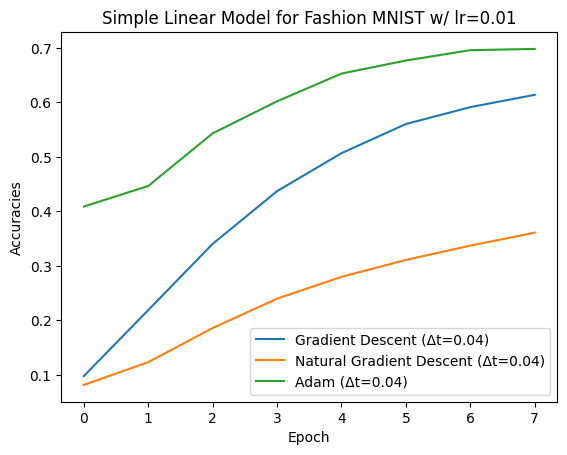

In [20]:
epochs = range(num_epochs)


plt.plot(epochs, SLMFMNISTGD_accuracies, label=f'Gradient Descent (Δt={mean(SLMFMNISTGD_training_times):.2f})')
plt.plot(epochs, SLMFMNISTNGD_accuracies, label=f'Natural Gradient Descent (Δt={mean(SLMFMNISTNGD_training_times):.2f})')
plt.plot(epochs, SLMFMNISTAO_accuracies, label=f'Adam (Δt={mean(SLMFMNISTAO_training_times):.2f})')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title(f'Simple Linear Model for Fashion MNIST w/ lr={learning_rate:.2f}')
plt.show()

# Systematizing the experiment

In [21]:
def simple_linear_comparison(learning_rate=0.1, lasso_hyperparameter=0):
  SLMFMNISTGD = SimpleLinear(input_size=28*28, num_classes=10)
  gd_optimizer = torch.optim.SGD(SLMFMNISTGD.parameters(), lr=learning_rate)

  SLMFMNISTNGD = SimpleLinear(input_size=28*28, num_classes=10)
  ngd_optimizer = NGD(SLMFMNISTNGD.parameters(), lr=learning_rate)

  SLMFMNISTAO = SimpleLinear(input_size=28*28, num_classes=10)
  adam_optimizer = torch.optim.Adam(SLMFMNISTAO.parameters(), lr=learning_rate)

  (SLMFMNISTGD_trained,
  SLMFMNISTGD_training_times,
  SLMFMNISTGD_accuracies) = model_train(model=SLMFMNISTGD,
                                              criterion=crossent_criterion,
                                              optimizer=gd_optimizer,
                                              trainloader=trainloader,
                                              testloader=testloader,
                                              num_epochs=num_epochs,
                                              lasso_hyperparameter=lasso_hyperparameter)

  (SLMFMNISTNGD_trained,
  SLMFMNISTNGD_training_times,
  SLMFMNISTNGD_accuracies) = model_train(model=SLMFMNISTNGD,
                                              criterion=crossent_criterion,
                                              optimizer=ngd_optimizer, #*natural*
                                              trainloader=trainloader,
                                              testloader=testloader,
                                              num_epochs=num_epochs,
                                              lasso_hyperparameter=lasso_hyperparameter)

  (SLMFMNISTAO_trained,
  SLMFMNISTAO_training_times,
  SLMFMNISTAO_accuracies) = model_train(model=SLMFMNISTAO,
                                              criterion=crossent_criterion,
                                              optimizer=adam_optimizer,
                                              trainloader=trainloader,
                                              testloader=testloader,
                                              num_epochs=num_epochs,
                                              lasso_hyperparameter=lasso_hyperparameter)

  epochs = range(num_epochs)
  plt.plot(epochs, SLMFMNISTGD_accuracies, label=f'Gradient Descent (Δt={mean(SLMFMNISTGD_training_times):.2f})')
  plt.plot(epochs, SLMFMNISTNGD_accuracies, label=f'Natural Gradient Descent (Δt={mean(SLMFMNISTNGD_training_times):.2f})')
  plt.plot(epochs, SLMFMNISTAO_accuracies, label=f'Adam (Δt={mean(SLMFMNISTAO_training_times):.2f})')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracies')
  plt.title(f'Simple Linear Model for Fashion MNIST w/ lr={learning_rate:.2f}')
  plt.show()

# Running the same experiment with a much higher learning rate

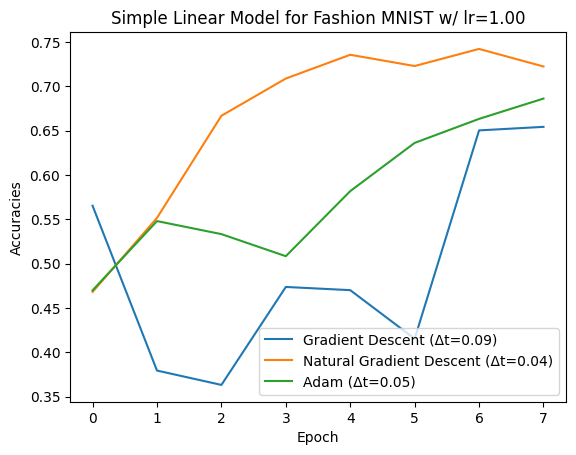

In [22]:
simple_linear_comparison(learning_rate=1.0)


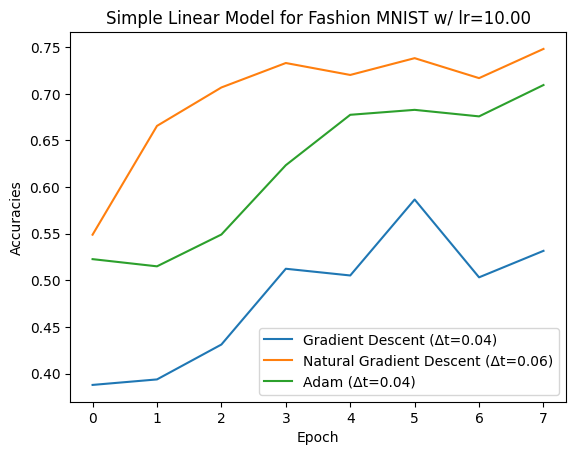

In [23]:
simple_linear_comparison(learning_rate=10.0)

If you want to get a good simple linear model with a small number of epochs, it is good to use natural gradient descent with a high learning rate. If you want to use a large number of epochs, it is better to use the Adam optimizer. If you want to have a balance, with a good model for a low learning rate and a small number of epochs, then it may be better to use standard gradient descent.

# Comparing the Same Three Optimizers for a Model with One Hidden Layer (OHL)

In [24]:
# You can modify the simple linear comparison function to be more like this
def one_hidden_comparison(learning_rate=0.01, hidden_size=100,  num_classes=10, num_epochs=8, activation_function=F.relu, lasso_hyperparameter=0):
  OHLFMNISTGD = OneHidden(input_size=28*28, hidden_size=hidden_size, num_classes=num_classes, activation_function=activation_function)
  gd_optimizer = torch.optim.SGD(OHLFMNISTGD.parameters(), lr=learning_rate)

  OHLFMNISTNGD = OneHidden(input_size=28*28, hidden_size=hidden_size, num_classes=num_classes, activation_function=activation_function)
  ngd_optimizer = NGD(OHLFMNISTNGD.parameters(), lr=learning_rate)

  OHLFMNISTAO = OneHidden(input_size=28*28, hidden_size=hidden_size, num_classes=num_classes, activation_function=activation_function)
  adam_optimizer = torch.optim.Adam(OHLFMNISTAO.parameters(), lr=learning_rate)

  (OHLFMNISTGD_trained,
  OHLFMNISTGD_training_times,
  OHLFMNISTGD_accuracies) = model_train(model=OHLFMNISTGD,
                                              criterion=crossent_criterion,
                                              optimizer=gd_optimizer,
                                              trainloader=trainloader,
                                              testloader=testloader,
                                              num_epochs=num_epochs,
                                              lasso_hyperparameter=lasso_hyperparameter)

  (OHLFMNISTNGD_trained,
  OHLFMNISTNGD_training_times,
  OHLFMNISTNGD_accuracies) = model_train(model=OHLFMNISTNGD,
                                              criterion=crossent_criterion,
                                              optimizer=ngd_optimizer, #*natural*
                                              trainloader=trainloader,
                                              testloader=testloader,
                                              num_epochs=num_epochs,
                                              lasso_hyperparameter=lasso_hyperparameter)

  (OHLFMNISTAO_trained,
  OHLFMNISTAO_training_times,
  OHLFMNISTAO_accuracies) = model_train(model=OHLFMNISTAO,
                                              criterion=crossent_criterion,
                                              optimizer=adam_optimizer,
                                              trainloader=trainloader,
                                              testloader=testloader,
                                              num_epochs=num_epochs,
                                              lasso_hyperparameter=lasso_hyperparameter)

  epochs = range(num_epochs)
  plt.plot(epochs, OHLFMNISTGD_accuracies, label=f'Gradient Descent (Δt={mean(OHLFMNISTGD_training_times):.2f})')
  plt.plot(epochs, OHLFMNISTNGD_accuracies, label=f'Natural Gradient Descent (Δt={mean(OHLFMNISTNGD_training_times):.2f})')
  plt.plot(epochs, OHLFMNISTAO_accuracies, label=f'Adam (Δt={mean(OHLFMNISTAO_training_times):.2f})')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracies')
  plt.title(f'One Hidden Layer Model for Fashion MNIST w/ lr={learning_rate:.2f}, hidden_size={hidden_size:.2f}, λ={lasso_hyperparameter:.2f} F_act= '+activation_function.__name__)
  plt.show()

# What is the difference between these activation functions?

`tanh` is differentiable at every point, and permits negative values, while `ReLU` is not differentiable at every point, and converts negative values to zero. One might hypothesize that the natural gradient descent method will perform better with `tanh` than with `ReLU`, as the non-differentiability of `ReLU` at the origin may negate Fisher information's regularity conditions. But we only manage to show `tanh`'s superiority for natural gradient descent in for one hidden layer with a learning rate of 1.0 and no regularization, as shown.

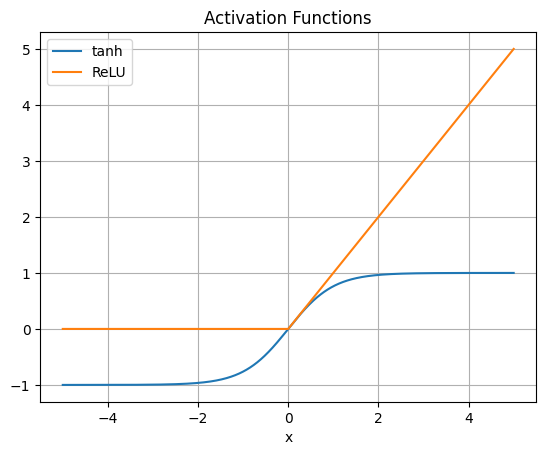

In [36]:
import numpy as np

_relu = lambda x: np.maximum(0, x)
domain = np.linspace(-5, 5, 1000)


plt.plot(domain, np.tanh(domain), label='tanh')
plt.plot(domain, _relu(domain), label='ReLU')
plt.title('Activation Functions')
plt.xlabel('x')
plt.legend()
plt.grid()
plt.show()

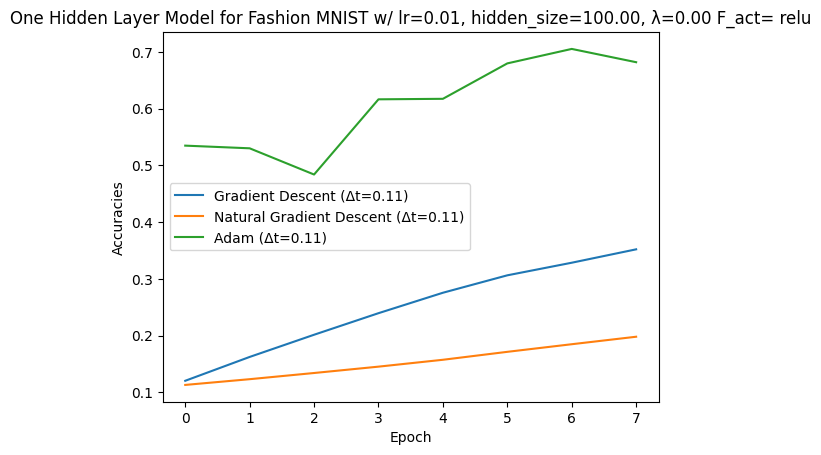

In [25]:
one_hidden_comparison()

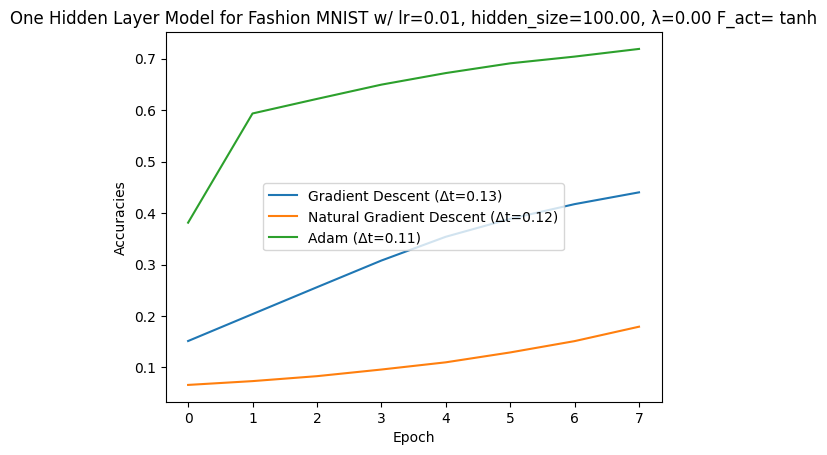

In [31]:
one_hidden_comparison(activation_function=F.tanh)

Here we see the Adam optimizer performing better than natural gradient descent even with both activation functions. What if we change the learning rate?

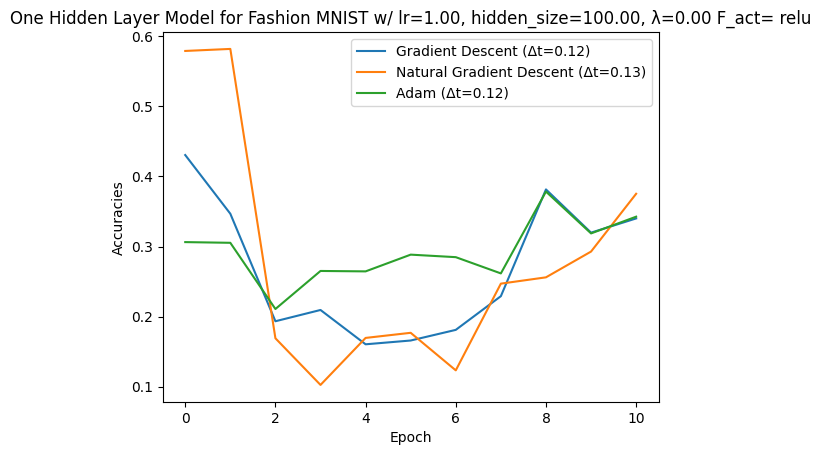

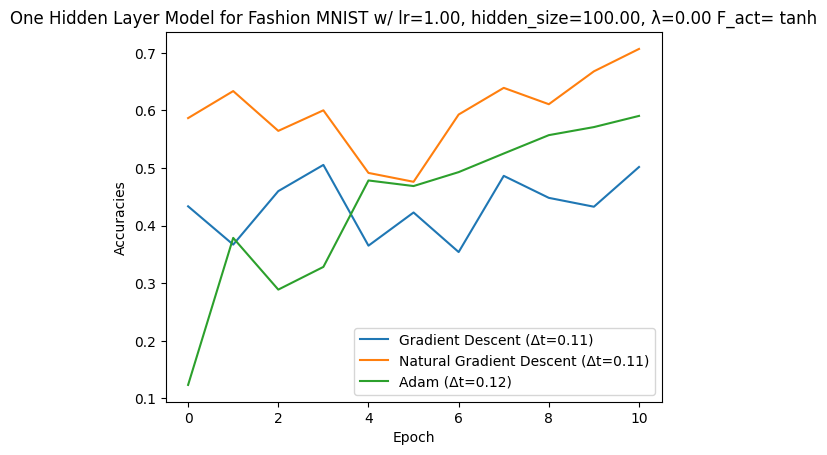

In [27]:
one_hidden_comparison(learning_rate=1.0, num_epochs=11, activation_function=F.relu)
one_hidden_comparison(learning_rate=1.0, num_epochs=11, activation_function=F.tanh)

With a higher learning rate, we see the Natural gradient descent performing better than Adam for tanh, but worse than Adam for ReLU (at least for this many epochs). This may be because the Fisher information matrix is more suited for a statistical manifold influenced by the differentiable tanh.

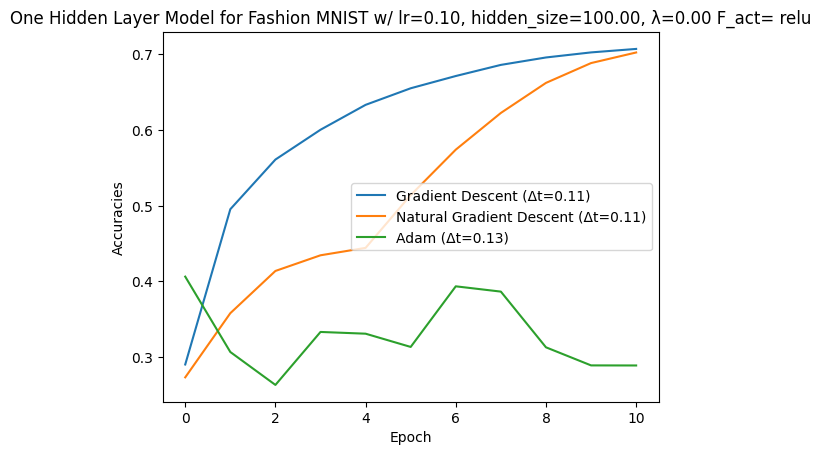

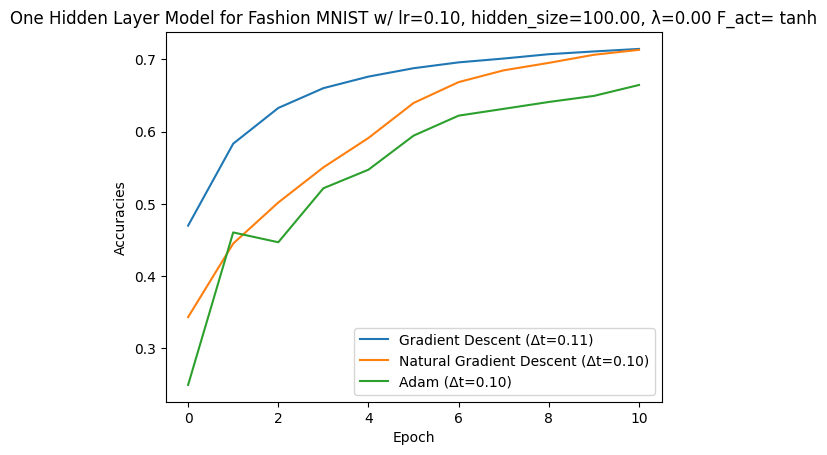

In [28]:
one_hidden_comparison(learning_rate=0.1, num_epochs=11, activation_function=F.relu)
one_hidden_comparison(learning_rate=0.1, num_epochs=11, activation_function=F.tanh)

The above output with 

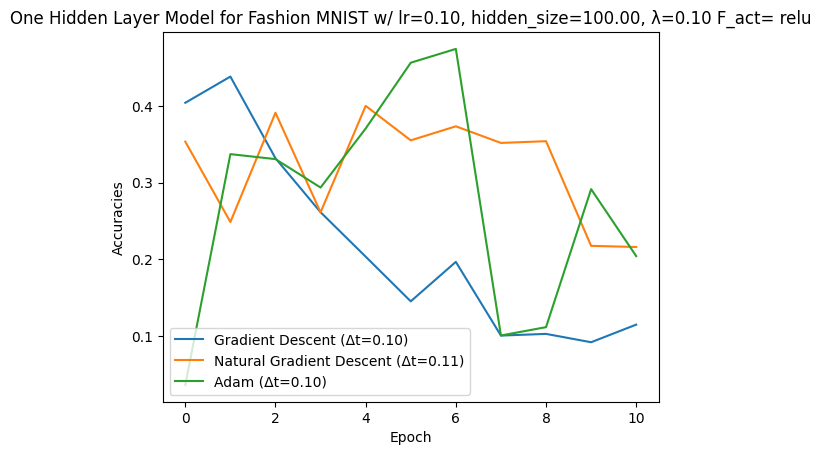

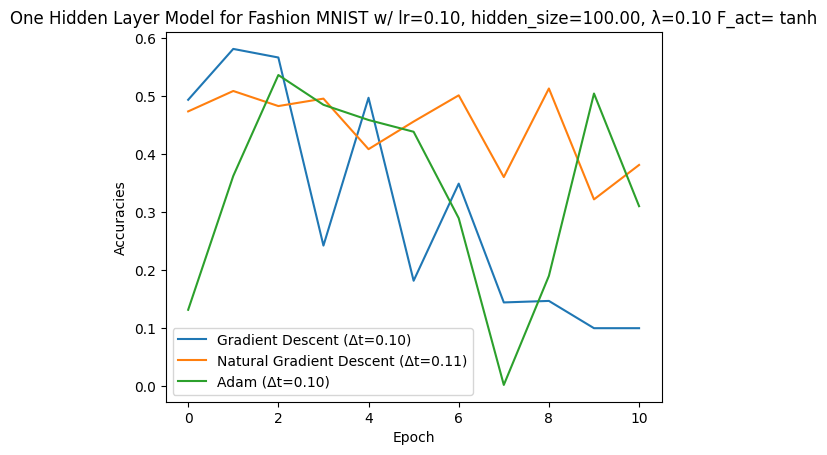

In [29]:
one_hidden_comparison(learning_rate=0.1, num_epochs=11, activation_function=F.relu, lasso_hyperparameter=0.1)
one_hidden_comparison(learning_rate=0.1, num_epochs=11, activation_function=F.tanh, lasso_hyperparameter=0.1)

It seems like we may have regularized a little too much These models are not consistently learning. On the next cell, we decrease the penalty term.

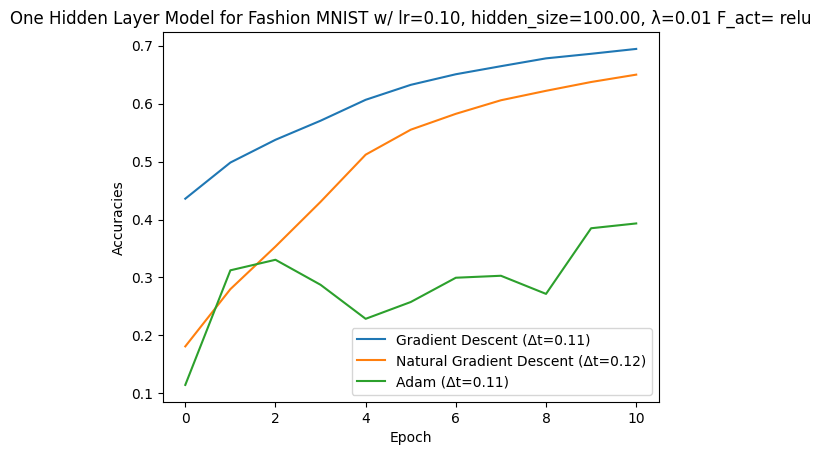

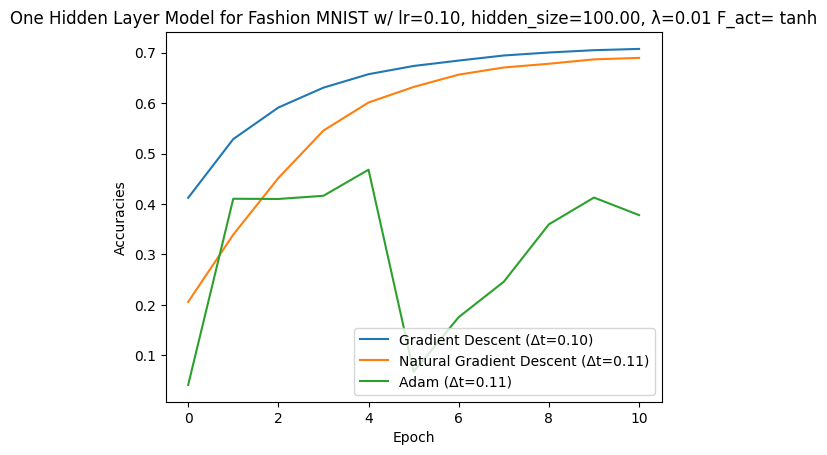

In [30]:
one_hidden_comparison(learning_rate=0.1, num_epochs=11, activation_function=F.relu, lasso_hyperparameter=0.01)
one_hidden_comparison(learning_rate=0.1, num_epochs=11, activation_function=F.tanh, lasso_hyperparameter=0.01)

For this learning rate, gradient descent is the best algorithm, and tanh as the activation function appears to get the fastest convergence. 

# Conclusions and Next steps:
There are limitations to comparing these optimization algorithms with the same learning rates. It is possible that, for each algorithm, one should find the best learning rate before comparing their accuracies. Optimizing the hyperparameters first will allow for a better sense of which algorithm is more effective.

With a hidden layer model and 1.0 learning rate, the `tanh` function leads to natural gradient descent being the best algorithm, and this may be due to the differentiability of `tanh` satisfying the "regularity conditions" of information geometry. However, this was not a consistent observation across all models.

More powerful devices, for example hypothetical analog thermodynamic computers, may allow us to overcome the limitations of low-rank natural gradient descent approximation, by making it more feasible to obtain precise natural gradients.

The best choices of model architecture, activation functions, LASSO penalty, and optimization algorithm varies greatly with the problem and the goal of the model. Such choices are difficult to make on the part of theory alone, and require more rigorous empirical testing, especially for the choice of hyperparameters.

# References

1. Kunstner, F.; Balles, L.; Hennig, P. Limitations of the Empirical Fisher Approximation for Natural Gradient Descent. arXiv:1905.12558
[cs.LG], May 29, 2019.

2. Hwang, D. FAdam: Adam is a natural gradient optimizer using diagonal empirical Fisher information. arXiv:2405.12807 [cs.LG], May 21, 2024.

3. Donatella, K.; Duffield, S.; Aifer, M.; Melanson, D.; Crooks, G.; Coles, P. J. Thermodynamic Natural Gradient Descent. arXiv:2405.13817, May 22, 2024.

4. Jones, A. Natural gradients. https://andrewcharlesjones.github.io/journal/natural-gradients.html (accessed May 14, 2025).

5. Ferrari, F. An Introduction to Gradient Descent: A Powerful Optimization Algorithm. Medium. February 12, 2023. https://medium.com/@fabrizioferrari/an-introduction-to-gradient-descent-a-powerful-optimization-algorithm-ff322ca264bf (accessed May 14, 2025).

6. Brownlee, J. Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. Machine Learning Mastery. January 13, 2021. https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ (assuming this is the correct URL, as it was not provided). (accessed May 14, 2025).

7. Mucci, T. What is data leakage in machine learning? IBM. https://www.ibm.com/topics/data-leakage (assuming this is a representative URL from IBM on the topic, as a specific one was not provided). (accessed May 14, 2025).

8. Van den Broeck, C. Stochastic thermodynamics: A brief introduction. In Physics of Complex Colloids; IOS Press, 2013; pp 155-193. DOI:10.3254/978-1-61499-278-3-155.

9. Nicholson, S. B.; García-Pintos, L. P.; del Campo, A.; Green, J. R. Time–information uncertainty relations in thermodynamics. Nat. Phys. 2020, 16, 1211–1215. https://doi.org/10.1038/s41567-020-0981-y (The September 2014 date seems to be an error in the provided information, as the journal publication date is 2020).
https://arxiv.org/pdf/1905.12558

In [2]:
import sys
print(sys.version)

3.13.3 (main, Apr  9 2025, 07:44:25) [GCC 14.2.1 20250207]
